# **CLASE 9 - Simular un portafolio usando MGB**

Julieta Madrigal Flores

Martes 19 de febrero del 2026

In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [18]:
stocks = ["KR","KO","TSLA","ORCL"]
weights = np.array([0.25,0.25,0.25,0.25])

if not np.isclose(weights.sum(),1):
    raise ValueError("Los pesos deben sumar 1")

end = dt.datetime.now()
start = end - dt.timedelta(days=365*3)

In [19]:
prices = yf.download(stocks,start=start,end=end,progress=False)["Close"]
returns = prices.pct_change().dropna()

mean_returns = returns.mean()
cov_matrix = returns.cov()

print("Media diaria retornos:")
print(mean_returns)
print("\\nMatriz de covarianza:")
print(cov_matrix)

/tmp/ipython-input-2018562991.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(stocks,start=start,end=end,progress=False)["Close"]


Media diaria retornos:
Ticker
KO      0.000541
KR      0.000724
ORCL    0.001175
TSLA    0.001642
dtype: float64
\nMatriz de covarianza:
Ticker        KO        KR      ORCL      TSLA
Ticker                                        
KO      0.000088  0.000039 -0.000024 -0.000022
KR      0.000039  0.000213 -0.000037 -0.000053
ORCL   -0.000024 -0.000037  0.000807  0.000296
TSLA   -0.000022 -0.000053  0.000296  0.001356


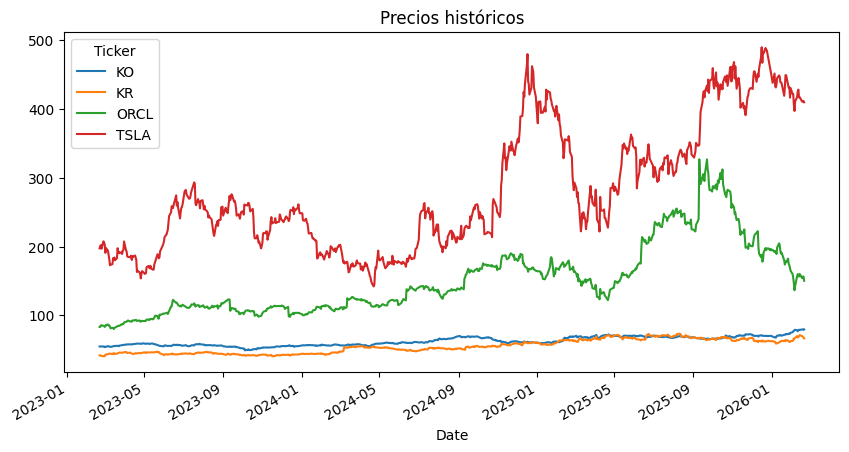

In [20]:
prices.plot(figsize=(10,5),title="Precios históricos")
plt.show()

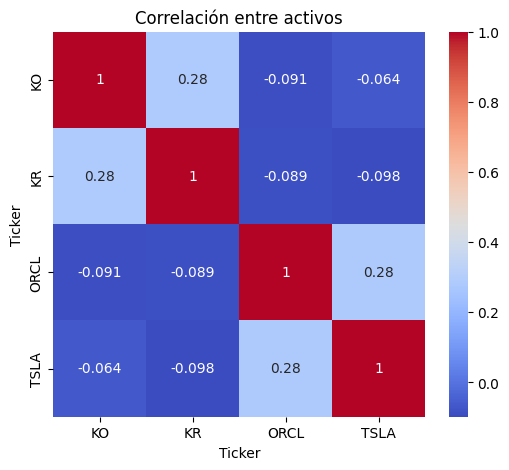

In [21]:
plt.figure(figsize=(6,5))
sns.heatmap(returns.corr(),annot=True,cmap="coolwarm")
plt.title("Correlación entre activos")
plt.show()

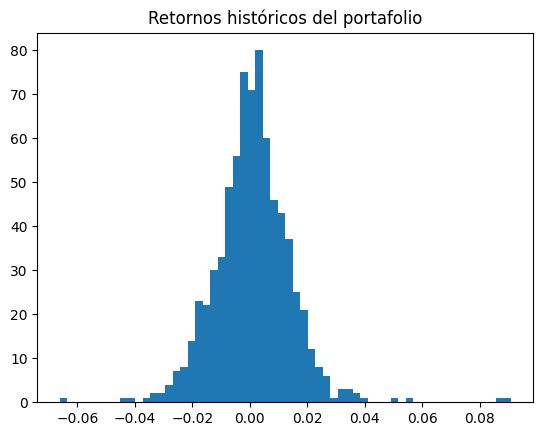

Volatilidad histórica diaria: 0.013373824883556389


In [22]:
portfolio_hist = returns.dot(weights)

plt.hist(portfolio_hist,bins=60)
plt.title("Retornos históricos del portafolio")
plt.show()

print("Volatilidad histórica diaria:", portfolio_hist.std())

In [23]:
num_sim = 5000
num_days = 252
k = len(stocks)

L = np.linalg.cholesky(cov_matrix)
portfolio_paths = np.zeros((num_days,num_sim))

In [24]:
for m in range(num_sim):

    Z = np.random.normal(size=(num_days,k))
    correlated = Z @ L.T
    daily_returns = correlated + mean_returns.values
    port_daily = daily_returns @ weights
    portfolio_paths[:,m] = np.cumprod(1+port_daily)

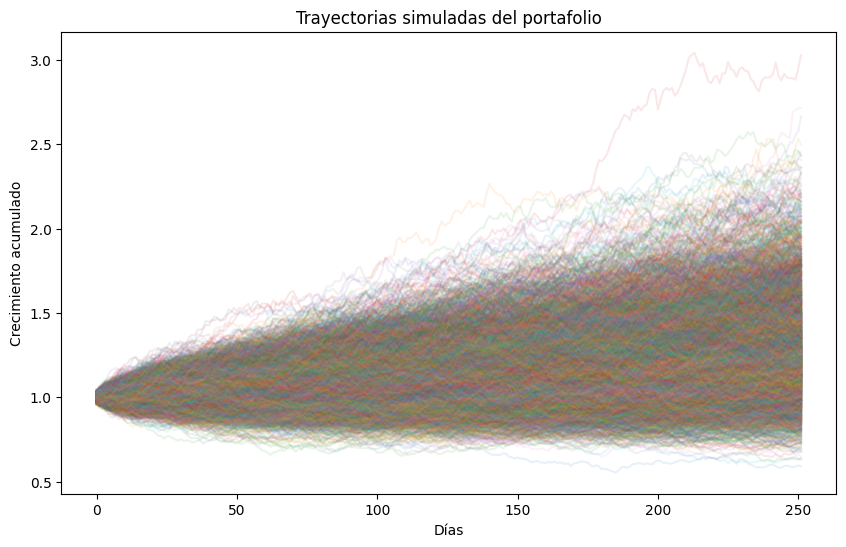

In [25]:
plt.figure(figsize=(10,6))
plt.plot(portfolio_paths,alpha=0.1)
plt.title("Trayectorias simuladas del portafolio")
plt.xlabel("Días")
plt.ylabel("Crecimiento acumulado")
plt.show()

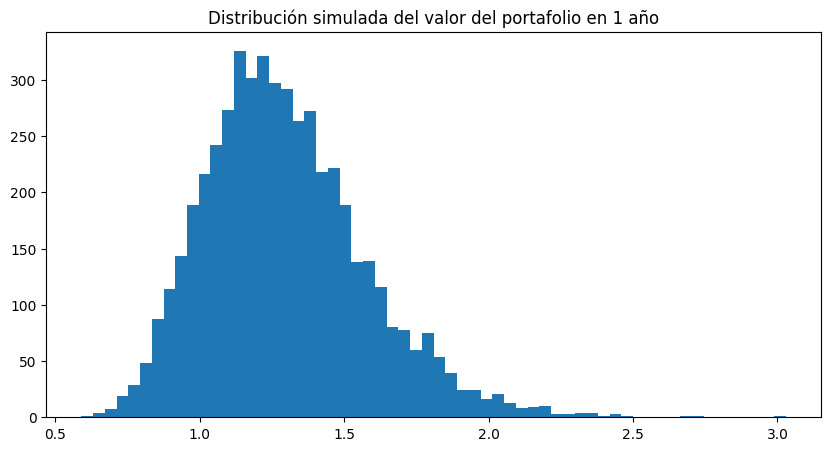

Valor esperado final: 1.2965965796203576
Probabilidad de pérdida: 0.1318


In [26]:
final_values = portfolio_paths[-1]

plt.figure(figsize=(10,5))
plt.hist(final_values,bins=60)
plt.title("Distribución simulada del valor del portafolio en 1 año")
plt.show()

print("Valor esperado final:", final_values.mean())
print("Probabilidad de pérdida:", np.mean(final_values<1))

In [27]:
final_values.min(), final_values.max()

(np.float64(0.5905966469513502), np.float64(3.029142185288935))

# **CLASE 10 - VaR con Monte Carlo y EWMA**

**Value at Risk** = la peor pérdida de un portafolio a lo largo de un horizonte de tiempo

In [28]:
lambda_ = 0.94

ewma_var = returns.var().copy()
ewma_vol_series = []

for t in range(len(returns)):
    r_t = returns.iloc[t]
    ewma_var = lambda_ * ewma_var + (1 - lambda_) * (r_t ** 2)
    ewma_vol_series.append(np.sqrt(ewma_var))

ewma_vol_df = pd.DataFrame(ewma_vol_series,
                           index=returns.index,
                           columns=returns.columns)

In [29]:
corr_matrix = returns.corr()
L_corr = np.linalg.cholesky(corr_matrix)

In [30]:
sigma_t = ewma_vol_df.iloc[-1].values # Initialize sigma_t with the last EWMA volatilities
n_assets = k # Use k for the number of assets
n_days = num_days # Use num_days for the number of days

for s in range(num_sim): # Changed n_sim to num_sim

    sigma = sigma_t.copy()
    prices_sim = np.ones(n_assets)

    for t in range(n_days):

        z = np.random.normal(size=n_assets)
        correlated = L_corr @ z

        r = sigma * correlated

        prices_sim = prices_sim * (1 + r)

        port_ret = np.dot(weights, r)

        if t == 0:
            portfolio_paths[t, s] = 1 + port_ret
        else:
            portfolio_paths[t, s] = portfolio_paths[t-1, s] * (1 + port_ret)

        sigma = np.sqrt(lambda_ * sigma**2 + (1 - lambda_) * (r**2))

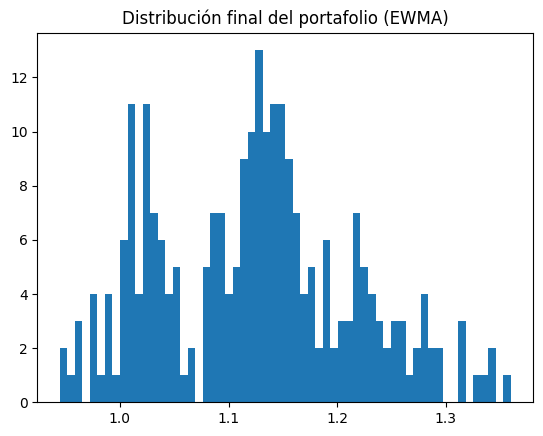

VaR 95%: 0.008598139038759056
Expected Shortfall 95%: 0.0317412515905241


In [31]:
final_values = portfolio_paths[:,-1]

plt.hist(final_values,bins=60)
plt.title("Distribución final del portafolio (EWMA)")
plt.show()

var_95 = np.percentile(final_values,5)
es_95 = final_values[final_values<=var_95].mean()

print("VaR 95%:",1-var_95)
print("Expected Shortfall 95%:",1-es_95)

## *Ejercicio de clase*

In [32]:
def calcular_var_portafolio(tickers, w, years, metodo="MGB", lamb=0.94, dias=15, sims=10000):
    """
    Calcula el VaR al 95% a N días.
    metodo: "MGB" (Volatilidad Constante) o "EWMA"
    """
    end = dt.datetime.now()
    start = end - dt.timedelta(days=365 * years)

    data = yf.download(tickers, start=start, end=end, progress=False)["Close"]
    returns = data.pct_change().dropna()

    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    k = len(tickers)

    portfolio_results = np.ones(sims)

    if metodo == "MGB":
        L = np.linalg.cholesky(cov_matrix)
        for _ in range(sims):
            Z = np.random.normal(size=(dias, k))
            daily_rets = (Z @ L.T) + mean_returns.values
            port_ret_path = daily_rets @ w
            portfolio_results[_] = np.prod(1 + port_ret_path)

    elif metodo == "EWMA":
        ewma_var = returns.var()
        for t in range(len(returns)):
            ewma_var = lamb * ewma_var + (1 - lamb) * (returns.iloc[t]**2)

        sigma_t = np.sqrt(ewma_var).values
        corr_matrix = returns.corr()
        L_corr = np.linalg.cholesky(corr_matrix)

        for s in range(sims):
            sigma_sim = sigma_t.copy()
            precios_relativos = 1.0
            for t in range(dias):
                z = np.random.normal(size=k)
                correlated_z = L_corr @ z
                r = sigma_sim * correlated_z

                port_ret = np.dot(w, r)
                precios_relativos *= (1 + port_ret)

                sigma_sim = np.sqrt(lamb * sigma_sim**2 + (1 - lamb) * (r**2))
            portfolio_results[s] = precios_relativos


    var_95 = 1 - np.percentile(portfolio_results, 5)
    return var_95 * 100

años_analisis = [1, 3, 5, 10]
resultados = []

print("Calculando simulaciones... por favor espere.")

for yrs in años_analisis:
    v_mgb = calcular_var_portafolio(stocks, weights, yrs, metodo="MGB")
    v_ewma_94 = calcular_var_portafolio(stocks, weights, yrs, metodo="EWMA", lamb=0.94)
    v_ewma_80 = calcular_var_portafolio(stocks, weights, yrs, metodo="EWMA", lamb=0.80)

    resultados.append({
        "Años de Data": yrs,
        "MGB Constante (%)": round(v_mgb, 4),
        "EWMA (λ=0.94) (%)": round(v_ewma_94, 4),
        "EWMA (λ=0.80) (%)": round(v_ewma_80, 4)
    })

df_comparativo = pd.DataFrame(resultados)
df_comparativo

Calculando simulaciones... por favor espere.


/tmp/ipython-input-942911758.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end, progress=False)["Close"]
/tmp/ipython-input-942911758.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end, progress=False)["Close"]
/tmp/ipython-input-942911758.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end, progress=False)["Close"]
/tmp/ipython-input-942911758.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end, progress=False)["Close"]
/tmp/ipython-input-942911758.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end, progress=False)["Close"]
/tmp/ipython-input-942911758.py:9: FutureWarning: 

,Años de Data,MGB Constante (%),EWMA (λ=0.94) (%),EWMA (λ=0.80) (%)
0,1,8.7646,7.6338,6.5410
1,3,6.9317,7.7492,6.6401
2,5,7.3602,8.1521,7.2764
3,10,7.1581,8.6016,7.4822


A partir de los resultados obtenidos se puede observar que la estimación del VaR puede variar dependiendo del horizonte temporal y el modelo de volatilidad. El modelo de MGB tiene el VaR más alto cuando se utiliza solo un año de los datos, lo cual hace referencia a un periodo de alta vólatilidad. Sin embargo al ampliar el horizonte, el VaR se empieza a estabilizarse, es decir, la volatilidad de largo plazo es menor y más estable = suaviza el riesgo estimado.

Por otro lado, el modelo EWMA con λ = 0.94, el VaR aumenta conforme se amplía el horizonte, esto sugiere que eventos de históricos de alta volatilidad siguen influyendo de manera relevante en la estimación. Mientras que con λ = 0.80, se le otorga mayor peso a los datos más recientes y reduce la importancia del pasado = más drámatico pero también más conservador.